In [1]:
import numpy as np

In [2]:
import pickle

In [3]:
import matplotlib.pyplot as plt


In [4]:
with open('../../data/indices/12500-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

12500

In [5]:
scores_list = []

In [6]:
with open("val_5000_0.5_loss_10_5000000.0_0.09693630065929029.pkl", 'rb') as handle:
    scores = pickle.load(handle)
scores_list.append(scores)
scores.shape

(1000, 12500)

In [7]:
with open("val_5000_0.5_loss_100_5000000.0_0.2105536611350098.pkl", 'rb') as handle:
    scores = pickle.load(handle)
scores_list.append(scores)
scores.shape

(1000, 12500)

In [8]:
# load ground truth
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [9]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/12500-0.5/lds-val/sd-lora-sub-{}-{}/e-{}-val.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

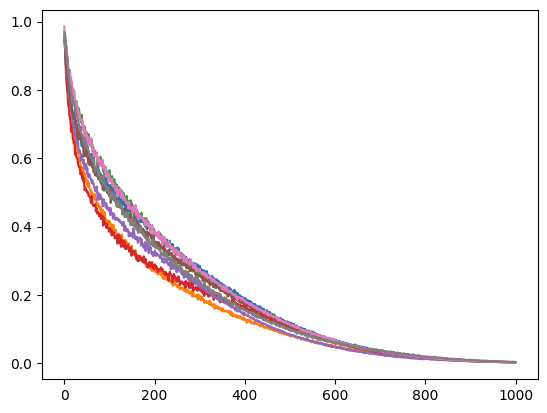

In [10]:
for i in range(1):
    for j in range(8):
        plt.plot(lds_loss_array[i, :, j], color="C{}".format(j))
    # break

In [11]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/12500-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 12500)

In [12]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

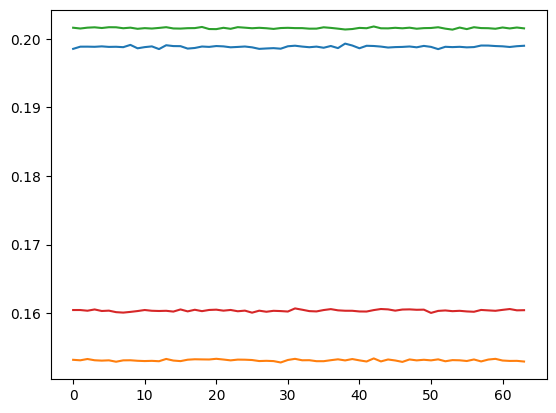

In [13]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [14]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -scores_list[0]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

# tmp_1 = rs

Correlation: 0.097 (avg p value 0.401023)


In [15]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -scores_list[1]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

# tmp_1 = rs

Correlation: 0.211 (avg p value 0.210921)


In [16]:
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [17]:
res_list = []
for i in range(2):
    print(i)
    def my_statistics(data):
        # print(data)
        # print(len(data))
        margins = lds_testset_correctness[data]
        infl_est_ = -scores_list[i]
        # infl_est_ = -tmp
        preds = lds_mask_array[data] @ infl_est_.T
        ####
        rs = []
        ps = []
        for ind in range(1000):
            r, p = spearmanr(preds[:, ind], margins[:, ind])
            # r, p = pearsonr(preds[:, ind], margins[:, ind])
            rs.append(r)
            ps.append(p)
        
        rs, ps = np.array(rs), np.array(ps)
        # print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
    
        return rs.mean()     

    data = (list(range(64)), )  # samples must be in a sequence
    res = bootstrap(data, my_statistics, 
                    n_resamples=64, # 够了估计
                    batch=128,
                    confidence_level=0.95,
                    random_state=42)

    print(res.confidence_interval)
    
    print(res.confidence_interval.low.round(3))
    print(res.confidence_interval.high.round(3))

    res_list.append(res)
    # break

0
ConfidenceInterval(low=0.09160137017603633, high=0.1034877199094092)
0.092
0.103
1
ConfidenceInterval(low=0.20503412545795943, high=0.2178758747195717)
0.205
0.218


In [18]:
[[res.confidence_interval.low, res.confidence_interval.high, res.bootstrap_distribution, res.standard_error] for res in res_list]

[[0.09160137017603633,
  0.1034877199094092,
  array([0.09165325, 0.09697451, 0.10048087, 0.09893272, 0.09688168,
         0.09327611, 0.09282833, 0.09183679, 0.10244653, 0.09468628,
         0.09548303, 0.09561201, 0.09927705, 0.09651581, 0.09802182,
         0.09944882, 0.0958204 , 0.09322748, 0.09182915, 0.09974222,
         0.09699851, 0.09733144, 0.09965372, 0.09470221, 0.09691336,
         0.09853868, 0.09880433, 0.09467009, 0.09551688, 0.09877911,
         0.09694779, 0.0985956 , 0.09131914, 0.09376685, 0.08993802,
         0.09225817, 0.09981762, 0.09138636, 0.09155529, 0.09752297,
         0.09439613, 0.09530667, 0.09590647, 0.10087081, 0.09608966,
         0.09820493, 0.09179087, 0.09401061, 0.09492751, 0.0965823 ,
         0.09425576, 0.095241  , 0.09247111, 0.09327861, 0.09520554,
         0.08791424, 0.10400336, 0.09162699, 0.09704754, 0.09600662,
         0.08914774, 0.09896333, 0.0975771 , 0.09462133]),
  0.0032443607667313927],
 [0.20503412545795943,
  0.217875874719571

In [19]:
with open("./val_res_list.pkl", 'wb') as handle:
    pickle.dump([[res.confidence_interval.low, res.confidence_interval.high, res.bootstrap_distribution, res.standard_error] for res in res_list],
                handle)

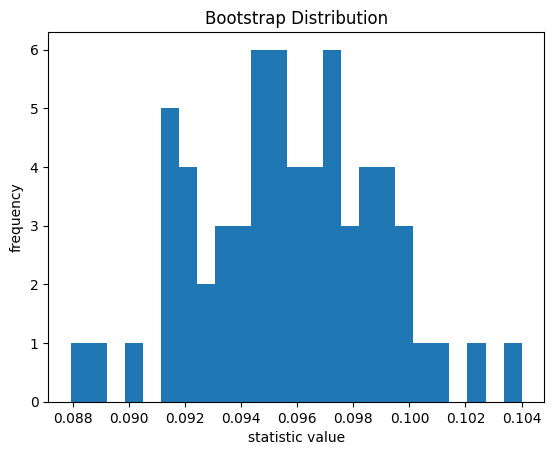

In [20]:
fig, ax = plt.subplots()
ax.hist(res_list[0].bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()